# Hyperparameter Tuning

## Goal

The goal of this notebook is to find the best combination of hyperparameters across a range of different regressor models and select the best model.

## Experiment
We conduct the experiment with following decisions:

- A time window of 1 year is used, starting with April 1st, 2017.
- We use the data raster created in the previous experiment.
- We perform hyperparameter tuning for the following models:
  - Extreme Learning Machine
  - K-Nearest Neighbors
  - Linear Regression fitted with Stochastic Gradient Descent
  - Support Vector Machine
  - Extra Trees
  - Histogram-based Gradient Boosting
  - Random Forest
  - eXtreme Gradient Boosting
- Bayesian Optimization with Optuna is used to find the best hyperparameters.
- The number of trials is set to 100 for all decision tree ensembles and 500 for all other models.
- The metric used is RMSE (Root Mean Squared Error).

We load the dataset and perform the hyperparameter tuning for each model:

In [1]:
# Define the metric and load the data
from sklearn.metrics import make_scorer, root_mean_squared_error
from ltm.features import load_raster

# Define the metric
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Load the data
data_path = "../data/processed/data.tif"
target_path = "../data/processed/target.tif"
data = load_raster(data_path)
target = load_raster(target_path)

# Drop rows with NaN in target
data, target = data[target.notna()], target[target.notna()]

In [2]:
# Create save folder and wrapper functions
from pathlib import Path

save_folder = "../models/"
Path(save_folder).mkdir(parents=True, exist_ok=True)


def suggest_categorical(*args, **kwargs):
    return "suggest_categorical", args, kwargs


def suggest_discrete_uniform(*args, **kwargs):
    return "suggest_discrete_uniform", args, kwargs


def suggest_float(*args, **kwargs):
    return "suggest_float", args, kwargs


def suggest_int(*args, **kwargs):
    return "suggest_int", args, kwargs

In [3]:
from skelm import ELMRegressor
from ltm.models import hyperparam_search

elm_model = ELMRegressor(random_state=42)
search_space = [
    suggest_float("alpha", 1e-8, 1e5, log=True),
    suggest_categorical("include_original_features", [True, False]),
    suggest_float("n_neurons", 1, 1000),
    suggest_categorical("ufunc", ["tanh", "sigm", "relu", "lin"]),
    suggest_float("density", 0.01, 0.99),
]

elm_pipe, elm_study = hyperparam_search(
    elm_model,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=500,
    save_folder=save_folder,
    random_state=42,
)

elm_pipe

Files already exist, skipping search: ..\models\ELMRegressor_study.pkl, ..\models\ELMRegressor.pkl


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('model',
                 ELMRegressor(alpha=181.50494096104447,
                              density=0.03017823893725209,
                              n_neurons=612.7512809079332, random_state=42,
                              ufunc='sigm'))])

In [4]:
# K-Nearest Neighbour
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_jobs=-1)
search_space = [
    suggest_int("n_neighbors", 1, 100),
    suggest_categorical("weights", ["uniform", "distance"]),
    suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
]

knn_pipe, knn_study = hyperparam_search(
    knn_model,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=500,
    save_folder=save_folder,
    random_state=42,
)

knn_pipe

Files already exist, skipping search: ..\models\KNeighborsRegressor_study.pkl, ..\models\KNeighborsRegressor.pkl


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=563)),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', n_jobs=-1,
                                     n_neighbors=42, weights='distance'))])

In [5]:
# SGD Linear Regression
from sklearn.linear_model import SGDRegressor

sgd_model = SGDRegressor(random_state=42)
search_space = [
    suggest_categorical(
        "loss",
        [
            "squared_error",
            "huber",
            "epsilon_insensitive",
            "squared_epsilon_insensitive",
        ],
    ),
    suggest_float("alpha", 1e-6, 1e5, log=True),
    suggest_float("l1_ratio", 0, 1),
]

sgd_pipe, sgd_study = hyperparam_search(
    sgd_model,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=500,
    save_folder=save_folder,
    random_state=42,
)

sgd_pipe

Files already exist, skipping search: ..\models\SGDRegressor_study.pkl, ..\models\SGDRegressor.pkl


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=725)),
                ('model',
                 SGDRegressor(alpha=48.39782214129511,
                              l1_ratio=0.2262576032303607, loss='huber',
                              random_state=42))])

In [6]:
# Support Vector Machine
from sklearn.svm import SVR

svr_model = SVR()
search_space = [
    suggest_float("C", 1e-5, 1e5, log=True),
    suggest_float("epsilon", 1e-5, 1e5, log=True),
    suggest_categorical("kernel", ["poly", "rbf", "sigmoid"]),
]

svr_pipe, svr_study = hyperparam_search(
    svr_model,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=500,
    save_folder=save_folder,
    random_state=42,
    always_standardize=True,  # TODO: pack this info into the paper
)

svr_pipe

Files already exist, skipping search: ..\models\SVR_study.pkl, ..\models\SVR.pkl


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('model',
                 SVR(C=0.37394429636583115, epsilon=5.2877223547544566e-05))])

In [7]:
from sklearn.ensemble import ExtraTreesRegressor

et_model = ExtraTreesRegressor(n_jobs=-1, random_state=42)
search_space = [
    suggest_int("n_estimators", 1, 200),
    suggest_float("min_impurity_decrease", 1e-5, 0.5, log=True),
    suggest_categorical("criterion", ["squared_error", "absolute_error"]),
]

et_pipe, et_study = hyperparam_search(
    et_model,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
)

et_pipe

Files already exist, skipping search: ..\models\ExtraTreesRegressor_study.pkl, ..\models\ExtraTreesRegressor.pkl


Pipeline(steps=[('imputer', KNNImputer()),
                ('model',
                 ExtraTreesRegressor(min_impurity_decrease=0.000502785226062706,
                                     n_estimators=155, n_jobs=-1,
                                     random_state=42))])

In [8]:
# HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

hgbr_model = HistGradientBoostingRegressor(random_state=42)
search_space = [
    suggest_int("max_iter", 100, 1000),
    suggest_float("learning_rate", 0.001, 0.5, log=True),
    suggest_int("max_leaf_nodes", 2, 1000),
    suggest_categorical("l2_regularization", [0, 1e-10, 1e-5, 1e-3, 1e-1, 1]),
]

hgbr_pipe, hgbr_study = hyperparam_search(
    hgbr_model,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
)

hgbr_pipe

Files already exist, skipping search: ..\models\HistGradientBoostingRegressor_study.pkl, ..\models\HistGradientBoostingRegressor.pkl


Pipeline(steps=[('model',
                 HistGradientBoostingRegressor(l2_regularization=1e-05,
                                               learning_rate=0.005798925497228454,
                                               max_iter=800, max_leaf_nodes=12,
                                               random_state=42))])

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_jobs=-1, random_state=42)
search_space = [
    suggest_int("n_estimators", 1, 200),
    suggest_int("max_depth", 1, 1000),
    suggest_float("max_features", 0.1, 1.0),
    suggest_float("min_samples_split", 1e-5, 0.5, log=True),
    suggest_float("min_samples_leaf", 1e-5, 0.5, log=True),
    suggest_categorical("bootstrap", [True, False]),
    suggest_categorical(
        "criterion",
        [
            "squared_error",
            "poisson",
            "friedman_mse",
        ],  # absolute error is too slow: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
    ),
]

rf_pipe, rf_study = hyperparam_search(
    rf_model,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
)

rf_pipe

Files already exist, skipping search: ..\models\RandomForestRegressor_study.pkl, ..\models\RandomForestRegressor.pkl


Pipeline(steps=[('model',
                 RandomForestRegressor(criterion='friedman_mse', max_depth=266,
                                       max_features=0.23526796793347085,
                                       min_samples_leaf=0.003967120067104282,
                                       min_samples_split=0.010786682101063937,
                                       n_estimators=113, n_jobs=-1,
                                       random_state=42))])

In [10]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_jobs=-1, random_state=42)
search_space = [
    suggest_int("n_estimators", 10, 200),
    suggest_int("max_depth", 1, 20),
    suggest_float("learning_rate", 0.001, 0.5, log=True),
    suggest_float("gamma", 0, 0.5),
    suggest_int("min_child_weight", 1, 11),
]

xgb_pipe, xgb_study = hyperparam_search(
    xgb_model,
    search_space,
    data,
    target,
    rmse_scorer,
    n_trials=100,
    save_folder=save_folder,
    random_state=42,
)

xgb_pipe

Files already exist, skipping search: ..\models\XGBRegressor_study.pkl, ..\models\XGBRegressor.pkl


Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0.02263403330811986,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.04202523026242301, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=193, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

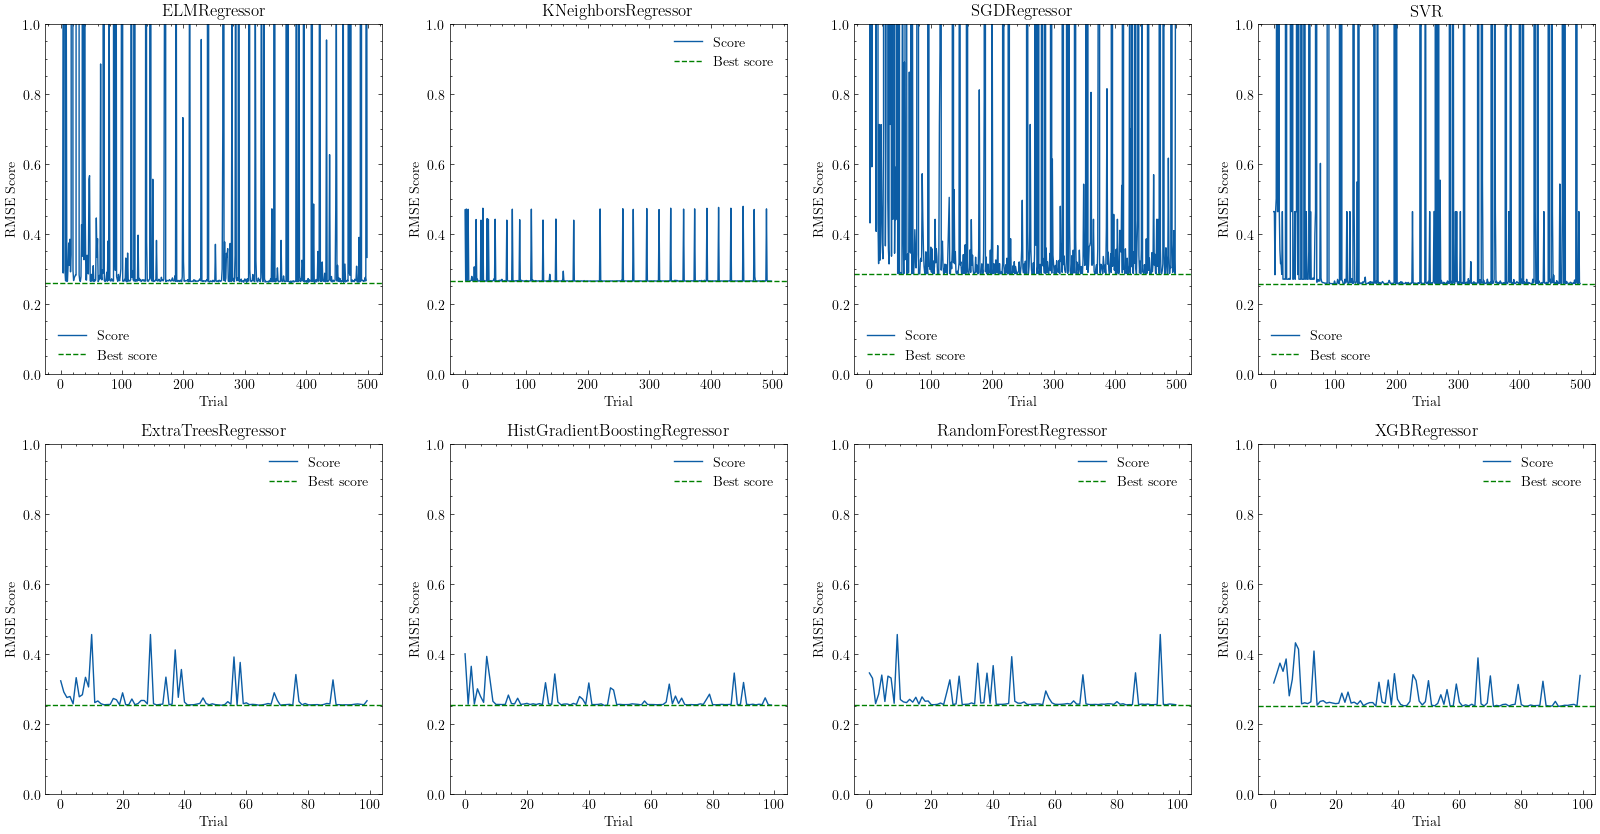

In [11]:
# Plot the hyperparam search scores during search
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

studies = [
    elm_study,
    knn_study,
    sgd_study,
    svr_study,
    et_study,
    hgbr_study,
    rf_study,
    xgb_study,
]

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for ax, study in zip(axs.flat, studies):
    trials = study.trials_dataframe()
    ax.plot(-trials["value"], label="Score")
    ax.set_title(study.study_name)
    ax.set_xlabel("Trial")
    ax.set_ylabel("RMSE Score")
    ax.axhline(-study.best_value, color="g", linestyle="--", label="Best score")
    ax.set_ylim(0, 1)
    ax.legend()

figure_path = f"../reports/figures/hyperparameter_tuning/Hyperparameter Tuning.svg"
Path(figure_path).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(figure_path, dpi=300)

In above figure you can see the hyperparameter tuning process for each model. The decision tree ensembles have a more stable RMSE value throughout the optimization process compared to the other models. We compute the RMSE, mean absolute error (MAE), and R2 score for each model. The best RMSE value is achieved by `XGBRegressor`:

In [12]:
import pandas as pd
from collections import defaultdict
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from tqdm.notebook import tqdm

csv_path = "../reports/hyperparameter_tuning.csv"
scoring = {
    "Root Mean Squared Error": make_scorer(root_mean_squared_error),
    "Mean Absolute Error": make_scorer(mean_absolute_error),
    "R2 Score": make_scorer(r2_score),
}

tuned_models = [
    elm_pipe,
    knn_pipe,
    sgd_pipe,
    svr_pipe,
    rf_pipe,
    et_pipe,
    hgbr_pipe,
    xgb_pipe,
]

if not Path(csv_path).exists():
    # Create columns
    model_names = [model.steps[-1][1].__class__.__name__ for model in tuned_models]
    columns = defaultdict(list)
    columns["Model"] = model_names

    # Cross validate default and tuned models
    for model in tqdm(tuned_models):
        cv_result = cross_validate(model, data, target, scoring=scoring, n_jobs=-1)

        for metric in scoring.keys():
            columns[metric].append(cv_result[f"test_{metric}"].mean())

    # Create dataframe
    df = pd.DataFrame(columns)
    df.set_index("Model", inplace=True)
    df.to_csv(csv_path)
else:
    df = pd.read_csv(csv_path, index_col="Model")

# Sort the dataframe by RMSE
df.sort_values("Root Mean Squared Error")

,Mean Absolute Error,Root Mean Squared Error,R2 Score
Model,,,
XGBRegressor,0.158959,0.250168,0.684720
HistGradientBoostingRegressor,0.159579,0.252941,0.677783
ExtraTreesRegressor,0.164691,0.253502,0.677133
RandomForestRegressor,0.166715,0.254584,0.674313
SVR,0.165773,0.258121,0.664555
ELMRegressor,0.183202,0.261034,0.657598
KNeighborsRegressor,0.164553,0.265418,0.646575
SGDRegressor,0.212896,0.286237,0.588798


We visualize the quality of the predictions per model by predicting on the study area using cross validation and plotting the predictions:

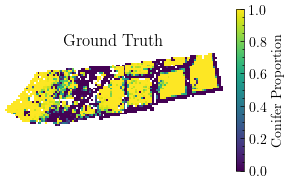

In [13]:
# Plot ground truth
import rasterio
import matplotlib as mpl

# Prepare the colormap
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=1)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# Create subplot and colorbar
fig, ax = plt.subplots()
fig.colorbar(mappable, ax=ax, label="Conifer Proportion", shrink=0.8)

# Load the target raster
with rasterio.open(target_path) as src:
    target_raster = src.read()

# Plot the target raster
ax.imshow(
    target_raster.transpose(1, 2, 0),
    interpolation="nearest",
    cmap=cmap,
    norm=norm,
)
ax.axis("off")
ax.set_title("Ground Truth")

figure_path = f"../reports/figures/hyperparameter_tuning/{ax.get_title()}.svg"
plt.savefig(figure_path, dpi=300)

  0%|          | 0/8 [00:00<?, ?it/s]

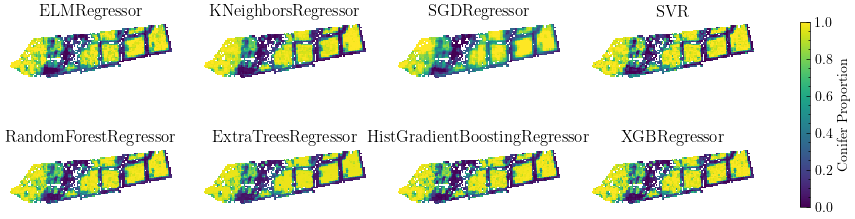

In [14]:
from ltm.models import cv_predict

fig, axs = plt.subplots(2, 4, figsize=(12, 3))
fig.colorbar(mappable, ax=axs, label="Conifer Proportion", shrink=0.8)

prediction_rasters = []
for ax, model in tqdm(list(zip(axs.flatten(), tuned_models))):
    path = f"../data/processed/hyperparameter_tuning/{model.steps[-1][1].__class__.__name__}.tif"
    if Path(path).exists():
        with rasterio.open(path) as src:
            prediction_raster = src.read()
    else:
        prediction_raster = cv_predict(model, data_path, target_path)
        with rasterio.open(target_path) as src:
            profile = src.profile

        with rasterio.open(path, "w", **profile) as dst:
            dst.write(prediction_raster)

    prediction_rasters.append(prediction_raster)

    im = ax.imshow(
        prediction_raster.transpose(1, 2, 0),
        interpolation="nearest",
        cmap=cmap,
        norm=norm,
    )
    ax.axis("off")
    ax.set_title(model.steps[-1][1].__class__.__name__)

figure_path = f"../reports/figures/hyperparameter_tuning/Predictions.svg"
plt.savefig(figure_path, dpi=300)

# Result

The best model is `XGBRegressor`. The visually and quanitatively worst model is `SGDRegressor`. The decision tree ensembles generally perform better than other models during hyperparameter tuning, as well as in the final evaluation. We visualize the predictions of the best model, `XGBRegressor`, in multiple ways to gain insights into the quality of the predictions and its limitations:

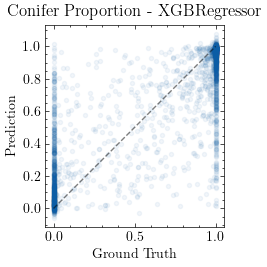

In [15]:
# Plot prediction raster of XGBoost to target raster
best_idx = df["Root Mean Squared Error"].argmin()
ax = plt.subplot()
ax.plot(
    target_raster.flatten(), prediction_rasters[best_idx].flatten(), ".", alpha=0.05
)
ax.set_aspect("equal")
ax.plot([0, 1], [0, 1], "--", color="k", alpha=0.5)

ax.set_title("Conifer Proportion - XGBRegressor")
ax.set_xlabel("Ground Truth")
ax.set_ylabel("Prediction")

figure_path = f"../reports/figures/hyperparameter_tuning/{ax.get_title()}.svg"
plt.savefig(figure_path, dpi=300)

While the predictions generally follow the patterns of the observed data, especially between the endmembers the predictions deviate significantly. This leads us to believe that the satellite data is not fully sufficient to capture the full complexity of the underlying data, but still enables a possibility for applying remote sensing to leaf type mixture prediction with a certain margin of error. At the endmembers, which are pixels with pure conifers or pure broadleafs, the predictions are concentrated at the correct values.

That said, using a digital elevation model (DEM) we could find a pattern to the quality of predictions:

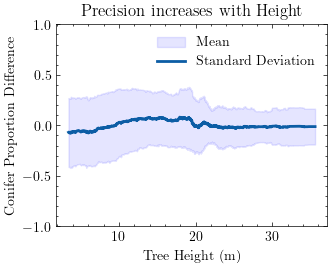

In [16]:
# Plot the difference between the prediction and target raster across the height of the trees
window_size = 200

dem = load_raster("../data/external/dem_median.tif")

target_df = pd.Series(target_raster.flatten())
prediction_df = pd.Series(prediction_rasters[best_idx].flatten())
dem_df = pd.Series(dem.values)

mask = target_df.notna()
difference_df = prediction_df - target_df
difference_df, dem_df = difference_df[mask], dem_df[mask]

dem_df = dem_df.reset_index(drop=True)
difference_df = difference_df.reset_index(drop=True)
indices = dem_df.argsort()
difference_df, dem_df = difference_df[indices], dem_df[indices]

difference_mean = difference_df.rolling(window_size).mean()
difference_std = difference_df.rolling(window_size).std()
ax = plt.subplot()
ax.fill_between(
    dem_df,
    (difference_mean - difference_std),
    (difference_mean + difference_std),
    color="b",
    alpha=0.1,
)
ax.plot(dem_df, difference_mean, linewidth=2)

# Format the plot
ax.set_ylim(-1, 1)
ax.set_xlabel("Tree Height (m)")
ax.set_ylabel("Conifer Proportion Difference")
ax.set_title("Precision increases with Height")
ax.legend(["Mean", "Standard Deviation"])

figure_path = f"../reports/figures/hyperparameter_tuning/{ax.get_title()}.svg"
plt.savefig(figure_path, dpi=300)

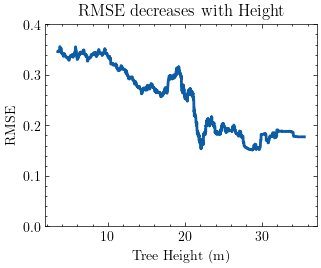

In [17]:
# Plot moving RMSE
import numpy as np

squared_error = difference_df**2
moving_rmse = np.sqrt(squared_error.rolling(window_size).mean())
ax = plt.subplot()
ax.plot(dem_df, moving_rmse, linewidth=2)
ax.set_ylim(0, 0.4)
ax.set_xlabel("Tree Height (m)")
ax.set_ylabel("RMSE")
ax.set_title("RMSE decreases with Height")

figure_path = f"../reports/figures/hyperparameter_tuning/{ax.get_title()}.svg"
plt.savefig(figure_path, dpi=300)

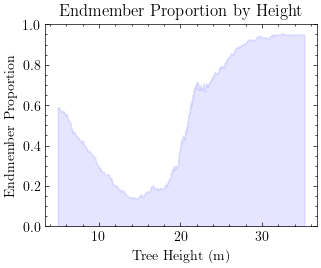

In [18]:
# Plot the percentage of endmembers across the height of the trees
dem = load_raster("../data/external/dem_median.tif")

target_df = pd.Series(target_raster.flatten())
prediction_df = pd.Series(prediction_rasters[best_idx].flatten())
dem_df = pd.Series(dem.values)

mask = (target_df == 0) | (target_df == 1)
endmembers = target_df[mask]
dem_df = dem_df[mask]

dem_df = dem_df.reset_index(drop=True)
endmembers = endmembers.reset_index(drop=True)
indices = dem_df.argsort()
endmembers, dem_df = endmembers[indices], dem_df[indices]
moving_average = endmembers.rolling(window_size).mean()

ax = plt.subplot()
ax.fill_between(dem_df, 0, moving_average, color="b", alpha=0.1)
ax.set_ylim(0, 1)
ax.set_xlabel("Tree Height (m)")
ax.set_ylabel("Endmember Proportion")
ax.set_title("Endmember Proportion by Height")

figure_path = f"../reports/figures/hyperparameter_tuning/{ax.get_title()}.svg"
plt.savefig(figure_path, dpi=300)

For taller trees, that is above roughly 20 meters, the predictions deviate way less, with the standard deviation being roughly half as much as for shorter trees. The RMSE reaches values below 0.2 and some as low as 0.15 compared to the combined RMSE of 0.25 for all tree heights. This is partly due to larger trees resulting more often in endmember pixels, as seen in the figure above. This is mostly due to the fact that only a few large trees of the same leaf type are needed to cover a whole 10x10 meter pixel.

The observation, that the endmember proportion icreases for small trees, is likely due to the fact that for young trees, only the ones planted often make the cut to be measured, while the natural rejuvenation, which mixes the leaf type is often not old enough to be measured.

With those results in mind, we recommend the usage of sattelite data to predict leaf type mixtures for larger trees, as the predictions are more accurate for those. For smaller trees, the predictions can still be useful, but the error margin is larger.